# Flower Classification 



In [ ]:
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")



Mounted at /content/drive/


In [ ]:
data_dir ="/content/drive/My Drive/Colab Notebooks/data_test"


In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir , transform=transformer)


In [ ]:
database.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'rose':2 ,
                  'sunflower':3 ,
                  'tulip':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [ ]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :daisy(0)


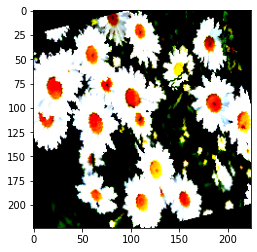

In [ ]:
show_sample(*database[1])

#Val_set and train_set

In [ ]:
validation_size = 80
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
test_ds, val_ds  = random_split(val_ds_main,[40, 40])
len(val_ds), len(train_ds)


(40, 25)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


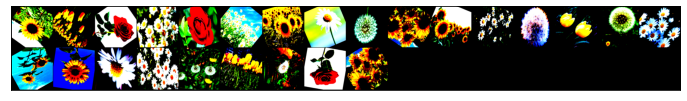

In [ ]:
show_batch(train_dl,invert=True)

# 1. Training Image Classification 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = FlowerModel()
model

FlowerModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
 for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([25, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([25, 5])
out[0]: tensor([-0.0136,  0.0337, -0.0149,  0.0196, -0.0379], grad_fn=<SelectBackward>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Training and Validation Dataset

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


In [ ]:
model = to_device(FlowerModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.125, 'val_loss': 1.6137504577636719}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6100, val_loss: 7.7764, val_acc: 0.2031
Epoch [1], train_loss: 5.6328, val_loss: 1.6847, val_acc: 0.1250
Epoch [2], train_loss: 1.6809, val_loss: 1.6189, val_acc: 0.1250
Epoch [3], train_loss: 1.6096, val_loss: 1.6238, val_acc: 0.1250
Epoch [4], train_loss: 1.5943, val_loss: 1.6224, val_acc: 0.2500
Epoch [5], train_loss: 1.5652, val_loss: 1.7953, val_acc: 0.2500
Epoch [6], train_loss: 1.5685, val_loss: 1.6705, val_acc: 0.2031
Epoch [7], train_loss: 1.5430, val_loss: 1.6213, val_acc: 0.2031
Epoch [8], train_loss: 1.5397, val_loss: 1.6042, val_acc: 0.2500
Epoch [9], train_loss: 1.5220, val_loss: 1.6149, val_acc: 0.2500
CPU times: user 8.06 s, sys: 1.67 s, total: 9.73 s
Wall time: 10.2 s


In [ ]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

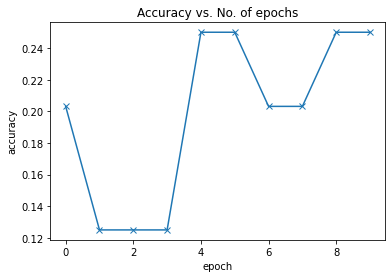

In [ ]:
plot_accuracies(try1)

In [ ]:
def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

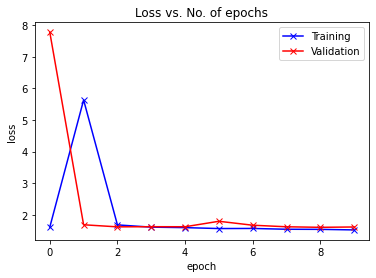

In [ ]:
plot_losses(try1)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_acc': 0.203125, 'val_loss': 1.6742181777954102}

# Predict the image 

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

In [ ]:
img, label = test_ds[]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

SyntaxError: ignored

In [ ]:
img, label = test_ds[5]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# 2. Transfer Learning method using Restnet50 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModelResnet50(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModelResnet50(), device)
evaluate(model, val_dl)

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

In [ ]:
evaluate(model, test_dl)

In [ ]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

In [ ]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

# Predict image

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

In [ ]:
img, label = test_ds[]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

In [ ]:
img, label = test_ds[2]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

# 3. Transfer Learning using Restnet18 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
evaluate(model, test_dl)


As you can see by using resnet 18  and tranfer learning the val_acc will be able to reach to 85%. It is more better then resnet50 and CNN(Bulid from scratch)

In [ ]:
def plot_accuracies(try3):
    accuracies = [x['val_acc'] for x in try3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try3)

In [ ]:
def plot_losses(try3):
    train_losses = [x.get('train_loss') for x in try3]
    val_losses = [x['val_loss'] for x in try3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try3)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

In [ ]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))


In [ ]:
img, label = test_ds[39]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))



In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')